In [ ]:
from google.colab import drive
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from natsort import natsorted
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, r2_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import os
import pandas as pd
import sys
import warnings
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.models import Sequential
from natsort import natsorted
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import os
import pandas as pd
import sys
import warnings


from google.colab import drive
from keras.layers import Dense, Dropout, Flatten, GRU
from keras.models import Sequential
from natsort import natsorted
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import os
import pandas as pd
import warnings




from google.colab import drive
from keras.layers import Dense, Flatten, SimpleRNN
from keras.models import Sequential
from natsort import natsorted
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import os
import pandas as pd
import warnings


from natsort import natsorted
from prettytable import PrettyTable
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score
import numpy as np
import os
import pandas as pd
import sys
import warnings



from google.colab import drive
from natsort import natsorted
from prettytable import PrettyTable
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, r2_score
import numpy as np
import os
import pandas as pd
import warnings


from google.colab import drive
from keras.layers import Conv1D, Dense, Flatten
from keras.models import Sequential
from natsort import natsorted
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import os
import pandas as pd
import warnings


!pip install ctgan
from ctgan import CTGAN
from google.colab import drive
from natsort import natsorted
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score
import numpy as np
import os
import pandas as pd
import warnings



drive.mount('/content/drive')
warnings.filterwarnings('ignore')
file_path = '/content/drive/MyDrive/aaa/datasets/db_bench/readwrite_1/bclt.csv'
num_past_measurements = 20
test_ratio_in_percentage = 50
test_ratio = test_ratio_in_percentage / 100
data = pd.read_csv(file_path)
data = data.head(int(np.round(len(data) * 0.001)))
print('length of data: ', len(data))
data = data.reset_index()
test_size = int(np.round(len(data) * test_ratio))
train_data, test_data = data[:-test_size], data[-test_size:]
num_columns = train_data.shape[1]
prediction_indices = range(len(train_data), len(train_data) + test_size)
prediction_data = pd.DataFrame(prediction_indices, columns=['index'], index=prediction_indices)
for col in [column for column in train_data.columns if train_data[column].nunique() == 1]:
    prediction_data[col] = pd.Series(train_data[col].iloc[0]).repeat(test_size).values
columns_not_in_prediction = [col for col in train_data.columns.tolist() if col not in prediction_data.columns.tolist()]
unique_values_dict = {}
for col in columns_not_in_prediction:
    unique_values = train_data[col].nunique()
    unique_values_dict[col] = unique_values
continuous_columns = []
discrete_columns = []
for col, unique_values in unique_values_dict.items():
    if unique_values > 500:
        continuous_columns.append(col)
    else:
        discrete_columns.append(col)
model = CTGAN(verbose=False)
model.fit(train_data, discrete_columns, epochs=50)
ctgan_data = model.sample(test_size)
ctgan_data = ctgan_data.sort_values(by='time', ascending=True)
num_past_measurements = 20
start_index = len(data) - test_size
for col in columns_not_in_prediction:
    for i in range(1, num_past_measurements + 1):
        data[f'{col}_{i}'] = data[col].shift(i * 25)
        if data[f'{col}_{i}'].dtype == 'int64':
            data[f'{col}_{i}'].fillna(-1, inplace=True)
        elif data[f'{col}_{i}'].dtype == 'float64':
            data[f'{col}_{i}'].fillna(-1.0, inplace=True)
        if data[f'{col}_{i}'].dtype != data[col].dtype:
            data[f'{col}_{i}'] = data[f'{col}_{i}'].astype(data[col].dtype)
        train_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        test_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        prediction_data.loc[start_index:, f'{col}_{i}'] = data.loc[start_index:, f'{col}_{i}']
num_rows = int(np.round(len(train_data) * 0.05))
for col in columns_not_in_prediction:
    if col in continuous_columns:
        features = [f'{col}_{i}' for i in range(1, num_columns)]
        X_test = prediction_data[features]
        X_train = train_data[features].values[-num_rows:]
        y_train = train_data[col].values[-num_rows:]
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = np.where(y_pred < -1, -1, y_pred)
        if train_data[col].dtype == np.int64:
            y_pred = np.round(y_pred).astype(np.int64)
        prediction_data[col] = y_pred
for col in ctgan_data.columns:
    if col not in prediction_data.columns:
        prediction_data[col] = ctgan_data[col].values
columns_to_drop = ['index']
if columns_not_in_prediction:
    start_index = train_data.columns.get_loc(f'{columns_not_in_prediction[0]}_1')
    end_index = train_data.columns.get_loc(f'{columns_not_in_prediction[-1]}_{num_past_measurements}')
    columns_to_drop.extend(data.columns[start_index:end_index + 1])
data = data.drop(columns_to_drop, axis=1)
train_data = train_data.drop(columns_to_drop, axis=1)
test_data = test_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data[train_data.columns]
table = PrettyTable()
table.field_names = ["Column", "Score", "Metric"]
scores = {}
below_average = []
for col in prediction_data.columns:
    if col in continuous_columns:
        score = r2_score(test_data[col], prediction_data[col])
        if score < 0:
            score = 0
        metric = 'R-squared'
    else:
        score = accuracy_score(test_data[col], prediction_data[col])
        metric = 'Accuracy'
    if score <= 0.6:
        below_average.append(col)
    scores[col] = (score, metric)
sorted_scores = sorted(scores.items(), key=lambda x: x[1][0], reverse=True)
for col, (score, metric) in sorted_scores:
    table.add_row([col, f'{(score * 100):.2f}%', metric])
average_score = np.mean([score for score, metric in scores.values()])
table.add_row(["TOTAL", f'{(average_score * 100):.2f}%', 'Total'])
print(table)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.4 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
length of data:  4592
+-----------------+---------+-----------+
|      Column     |  Score  |   Metric  |
+-----------------+---------+-----------+
|      cf_id      | 100.00% |  Accuracy |
|      level      | 100.00% |  Accuracy |
|       sst       | 100.00% |  Accuracy |
|      caller     | 100.00% |  Accuracy |
|    no_insert    | 100.00% |  Accuracy |
|     table_id    | 100.00% |  Accuracy |
| sequence_number | 100.00% |  Accuracy |
|  block_key_size | 100.00% |  Accuracy |
|     key_size    | 100.00% |  Accuracy |
|   block_offset  | 100.00% |  Accuracy |
|        id       | 100.00% | R-squared |
|       time      |  99.26% | R-squared |
|      key_id     |  97.06% | R-squared |
|    data_size    

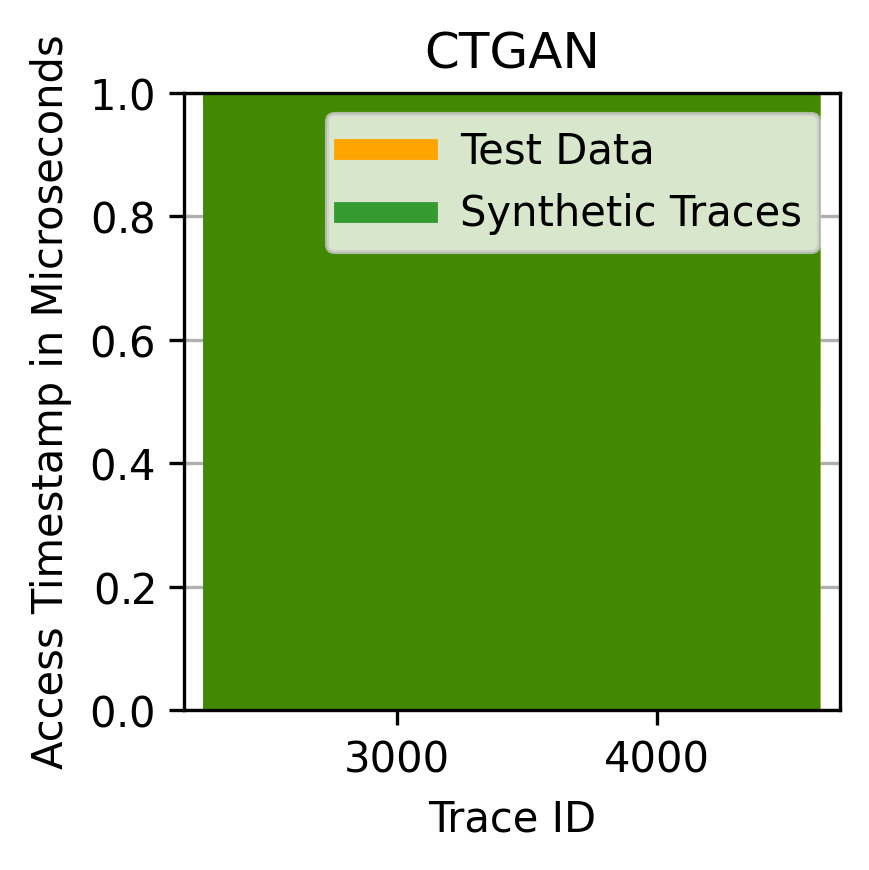

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'cache_hit':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('CTGAN')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Access Timestamp in Microseconds')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
from google.colab import drive
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
file_path = '/content/drive/MyDrive/aaa/datasets/db_bench/readwrite_1/bclt.csv'
num_past_measurements = 20
test_ratio_in_percentage = 50
test_ratio = test_ratio_in_percentage / 100
data = pd.read_csv(file_path)
data = data.head(int(np.round(len(data) * 0.001)))
print('length of data: ', len(data))
data = data.reset_index()
test_size = int(np.round(len(data) * test_ratio))
train_data, test_data = data[:-test_size], data[-test_size:]
num_columns = train_data.shape[1]
prediction_indices = range(len(train_data), len(train_data) + test_size)
prediction_data = pd.DataFrame(prediction_indices, columns=['index'], index=prediction_indices)
for col in [column for column in train_data.columns if train_data[column].nunique() == 1]:
    prediction_data[col] = pd.Series(train_data[col].iloc[0]).repeat(test_size).values
columns_not_in_prediction = [col for col in train_data.columns.tolist() if col not in prediction_data.columns.tolist()]
unique_values_dict = {}
for col in columns_not_in_prediction:
    unique_values = train_data[col].nunique()
    unique_values_dict[col] = unique_values
continuous_columns = []
discrete_columns = []
for col, unique_values in unique_values_dict.items():
    if unique_values > 500:
        continuous_columns.append(col)
    else:
        discrete_columns.append(col)
feature = 'index'
num_rows = int(np.round(len(train_data) * 0.05))
X_test = prediction_data[[feature]]
for col in columns_not_in_prediction:
    if col in continuous_columns:
        X_train = train_data[[feature]].values[-num_rows:]
        y_train = train_data[col].values[-num_rows:]
        model = LinearRegression()
    else:
        X_train = train_data[[feature]]
        y_train = train_data[col]
        model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred < -1, -1, y_pred)
    if train_data[col].dtype == np.int64:
        y_pred = np.round(y_pred).astype(np.int64)
    prediction_data[col] = y_pred
columns_to_drop = ['index']
data = data.drop(columns_to_drop, axis=1)
train_data = train_data.drop(columns_to_drop, axis=1)
test_data = test_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data[train_data.columns]
table = PrettyTable()
table.field_names = ["Column", "Score", "Metric"]
scores = {}
below_average = []
for col in prediction_data.columns:
    if col in continuous_columns:
        score = r2_score(test_data[col], prediction_data[col])
        if score < 0:
            score = 0
        metric = 'R-squared'
    else:
        score = accuracy_score(test_data[col], prediction_data[col])
        metric = 'Accuracy'
    if score <= 0.6:
        below_average.append(col)
    scores[col] = (score, metric)
sorted_scores = sorted(scores.items(), key=lambda x: x[1][0], reverse=True)
for col, (score, metric) in sorted_scores:
    table.add_row([col, f'{(score * 100):.2f}%', metric])
average_score = np.mean([score for score, metric in scores.values()])
table.add_row(["TOTAL", f'{(average_score * 100):.2f}%', 'Total'])
print(table)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
length of data:  4592
+-----------------+---------+-----------+
|      Column     |  Score  |   Metric  |
+-----------------+---------+-----------+
|      cf_id      | 100.00% |  Accuracy |
|      level      | 100.00% |  Accuracy |
|       sst       | 100.00% |  Accuracy |
|      caller     | 100.00% |  Accuracy |
|    no_insert    | 100.00% |  Accuracy |
|     table_id    | 100.00% |  Accuracy |
| sequence_number | 100.00% |  Accuracy |
|  block_key_size | 100.00% |  Accuracy |
|     key_size    | 100.00% |  Accuracy |
|   block_offset  | 100.00% |  Accuracy |
|        id       | 100.00% | R-squared |
|       time      |  99.74% | R-squared |
|      key_id     |  97.44% | R-squared |
|    data_size    |  90.51% |  Accuracy |
|    key_exist    |  90.51% |  Accuracy |
|    cache_hit    |  51.83% |  Accuracy |
|    block_type   |  50.04% |  Accuracy |
|    bloc

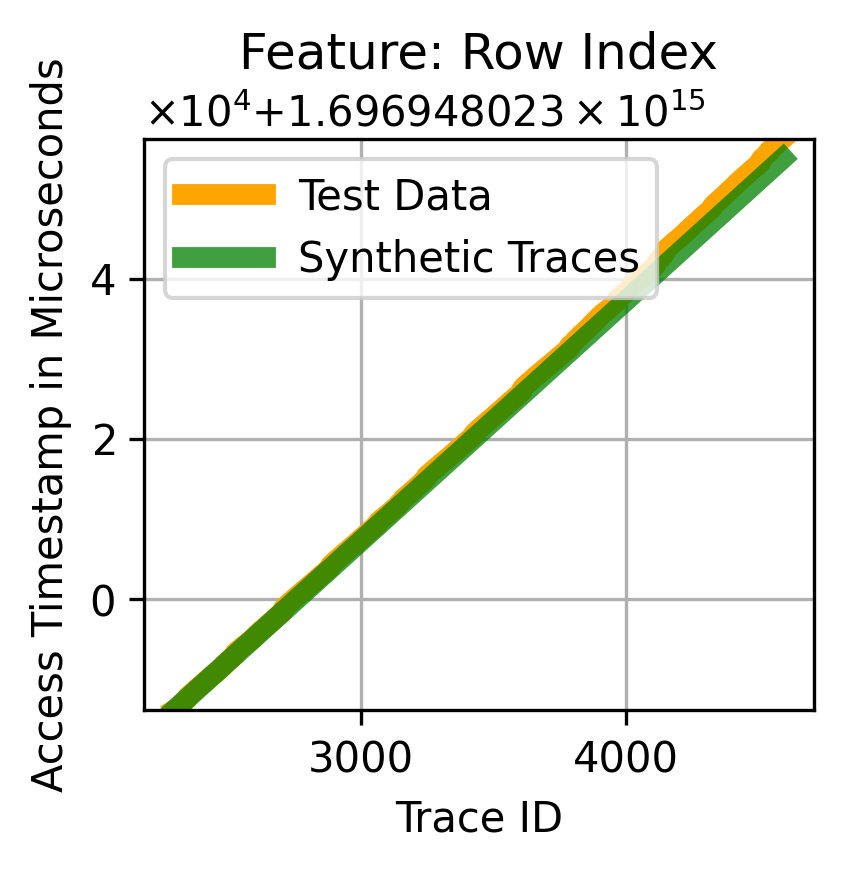

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'time':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Row Index')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Access Timestamp in Microseconds')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
from google.colab import drive
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
file_path = '/content/drive/MyDrive/aaa/datasets/db_bench/readwrite_1/bclt.csv'
num_past_measurements = 20
test_ratio_in_percentage = 50
test_ratio = test_ratio_in_percentage / 100
data = pd.read_csv(file_path)
data = data.head(int(np.round(len(data) * 0.001)))
print('length of data: ', len(data))
data = data.reset_index()
test_size = int(np.round(len(data) * test_ratio))
train_data, test_data = data[:-test_size], data[-test_size:]
num_columns = train_data.shape[1]
prediction_indices = range(len(train_data), len(train_data) + test_size)
prediction_data = pd.DataFrame(prediction_indices, columns=['index'], index=prediction_indices)
for col in [column for column in train_data.columns if train_data[column].nunique() == 1]:
    prediction_data[col] = pd.Series(train_data[col].iloc[0]).repeat(test_size).values
columns_not_in_prediction = [col for col in train_data.columns.tolist() if col not in prediction_data.columns.tolist()]
unique_values_dict = {}
for col in columns_not_in_prediction:
    unique_values = train_data[col].nunique()
    unique_values_dict[col] = unique_values
continuous_columns = []
discrete_columns = []
for col, unique_values in unique_values_dict.items():
    if unique_values > 500:
        continuous_columns.append(col)
    else:
        discrete_columns.append(col)
num_past_measurements = 20
start_index = len(data) - test_size
for col in columns_not_in_prediction:
    for i in range(1, num_past_measurements + 1):
        data[f'{col}_{i}'] = data[col].shift(i * 25)
        if data[f'{col}_{i}'].dtype == 'int64':
            data[f'{col}_{i}'].fillna(-1, inplace=True)
        elif data[f'{col}_{i}'].dtype == 'float64':
            data[f'{col}_{i}'].fillna(-1.0, inplace=True)
        if data[f'{col}_{i}'].dtype != data[col].dtype:
            data[f'{col}_{i}'] = data[f'{col}_{i}'].astype(data[col].dtype)
        train_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        test_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        prediction_data.loc[start_index:, f'{col}_{i}'] = data.loc[start_index:, f'{col}_{i}']
num_rows = int(np.round(len(train_data) * 0.05))
for col in columns_not_in_prediction:
    features = [f'{col}_{i}' for i in range(1, num_columns)]
    X_test = prediction_data[features]
    if col in continuous_columns:
        X_train = train_data[features].values[-num_rows:]
        y_train = train_data[col].values[-num_rows:]
        model = LinearRegression()
    else:
        X_train = train_data[features]
        y_train = train_data[col]
        model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred < -1, -1, y_pred)
    if train_data[col].dtype == np.int64:
        y_pred = np.round(y_pred).astype(np.int64)
    prediction_data[col] = y_pred
columns_to_drop = ['index']
if columns_not_in_prediction:
    start_index = train_data.columns.get_loc(f'{columns_not_in_prediction[0]}_1')
    end_index = train_data.columns.get_loc(f'{columns_not_in_prediction[-1]}_{num_past_measurements}')
    columns_to_drop.extend(data.columns[start_index:end_index + 1])
data = data.drop(columns_to_drop, axis=1)
train_data = train_data.drop(columns_to_drop, axis=1)
test_data = test_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data[train_data.columns]
table = PrettyTable()
table.field_names = ["Column", "Score", "Metric"]
scores = {}
below_average = []
for col in prediction_data.columns:
    if col in continuous_columns:
        score = r2_score(test_data[col], prediction_data[col])
        if score < 0:
            score = 0
        metric = 'R-squared'
    else:
        score = accuracy_score(test_data[col], prediction_data[col])
        metric = 'Accuracy'
    if score <= 0.6:
        below_average.append(col)
    scores[col] = (score, metric)
sorted_scores = sorted(scores.items(), key=lambda x: x[1][0], reverse=True)
for col, (score, metric) in sorted_scores:
    table.add_row([col, f'{(score * 100):.2f}%', metric])
average_score = np.mean([score for score, metric in scores.values()])
table.add_row(["TOTAL", f'{(average_score * 100):.2f}%', 'Total'])
print(table)

Mounted at /content/drive
length of data:  4592
+-----------------+---------+-----------+
|      Column     |  Score  |   Metric  |
+-----------------+---------+-----------+
|      cf_id      | 100.00% |  Accuracy |
|      level      | 100.00% |  Accuracy |
|       sst       | 100.00% |  Accuracy |
|      caller     | 100.00% |  Accuracy |
|    no_insert    | 100.00% |  Accuracy |
|     table_id    | 100.00% |  Accuracy |
| sequence_number | 100.00% |  Accuracy |
|  block_key_size | 100.00% |  Accuracy |
|     key_size    | 100.00% |  Accuracy |
|   block_offset  | 100.00% |  Accuracy |
|        id       | 100.00% | R-squared |
|       time      |  99.26% | R-squared |
|    block_type   |  98.91% |  Accuracy |
|    block_size   |  98.91% |  Accuracy |
|    key_count    |  98.91% |  Accuracy |
|      key_id     |  97.06% | R-squared |
|    cache_hit    |  95.34% |  Accuracy |
|    data_size    |  90.51% |  Accuracy |
|    key_exist    |  90.51% |  Accuracy |
|     block_id    |  35.28% 

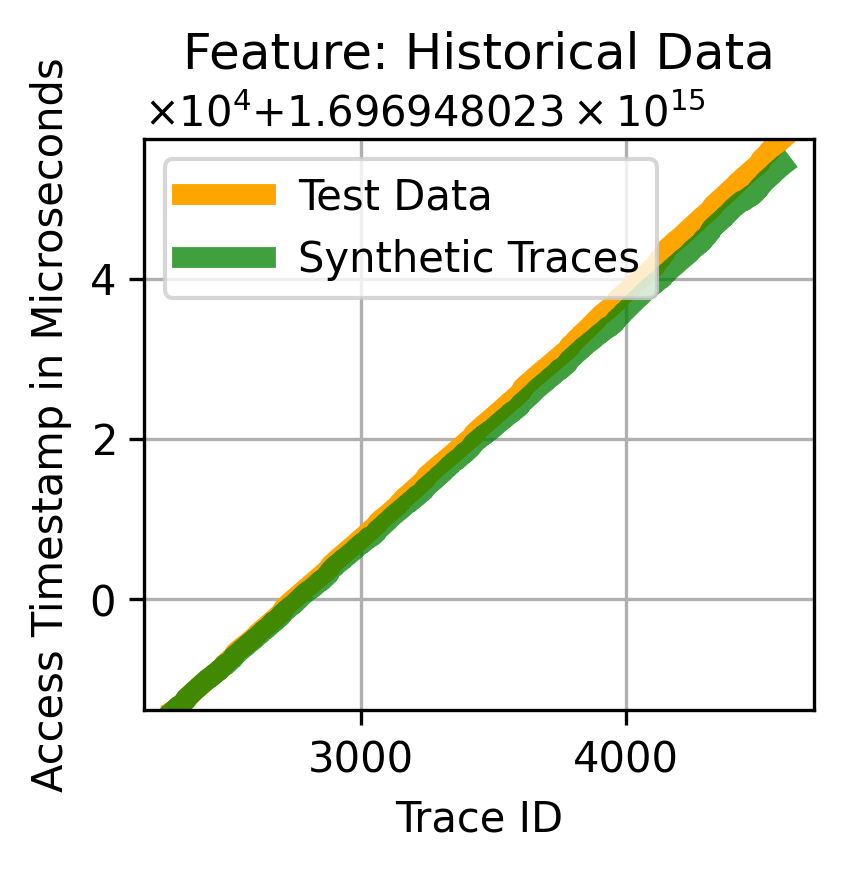

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'time':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Access Timestamp in Microseconds')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

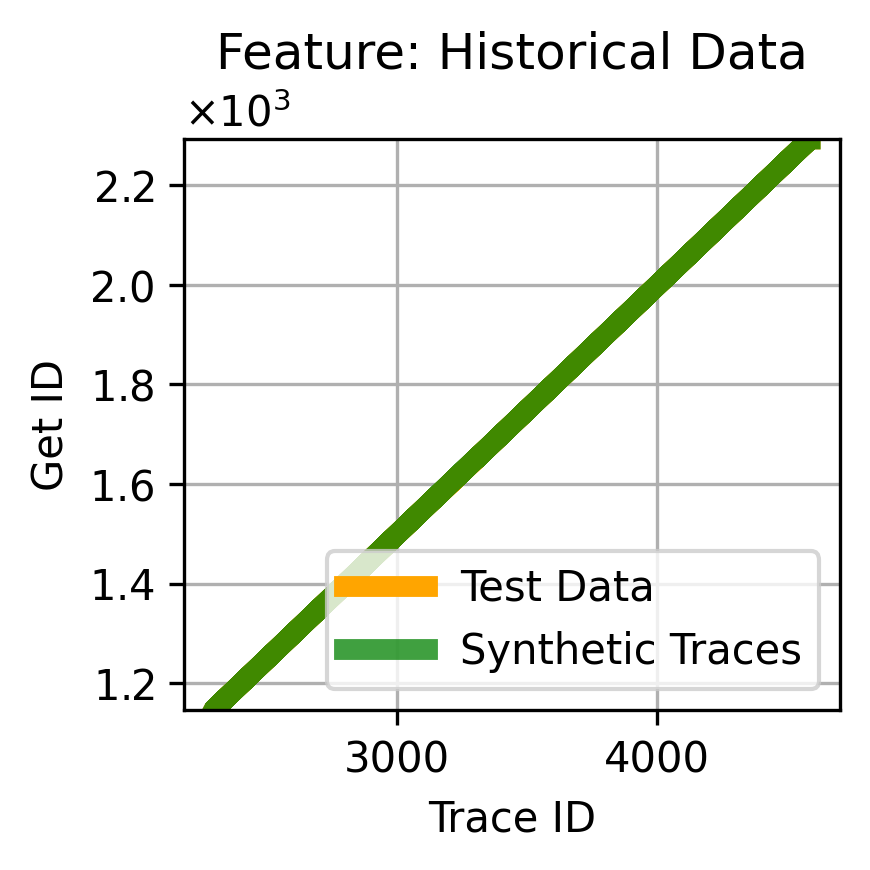

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'id':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Get ID')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

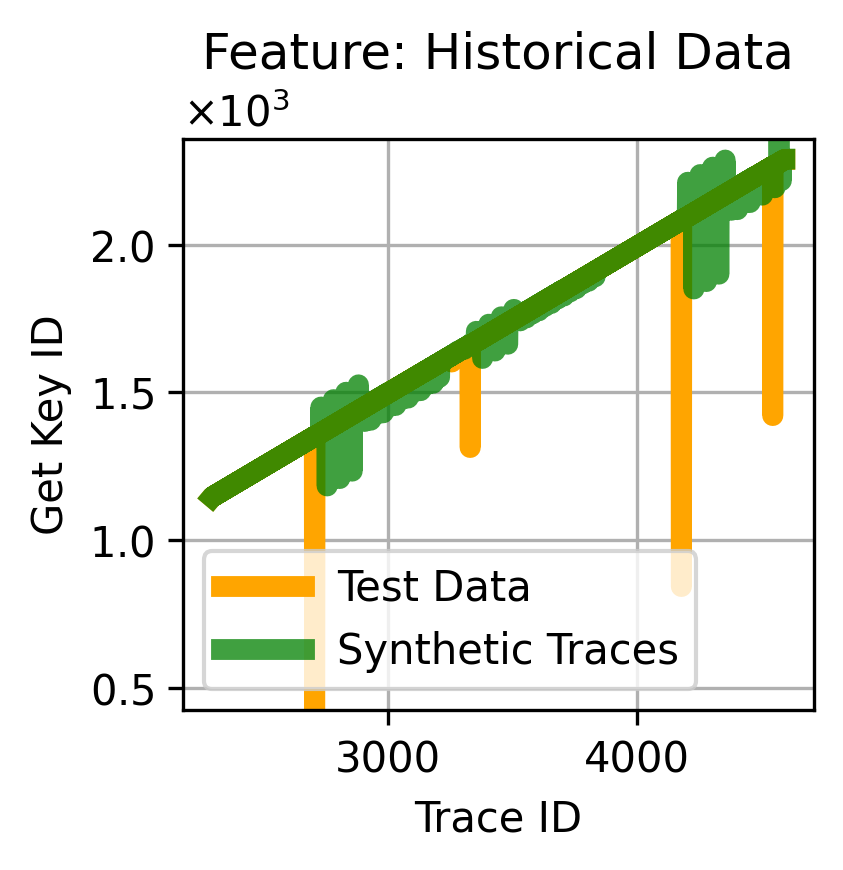

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'key_id':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Get Key ID')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

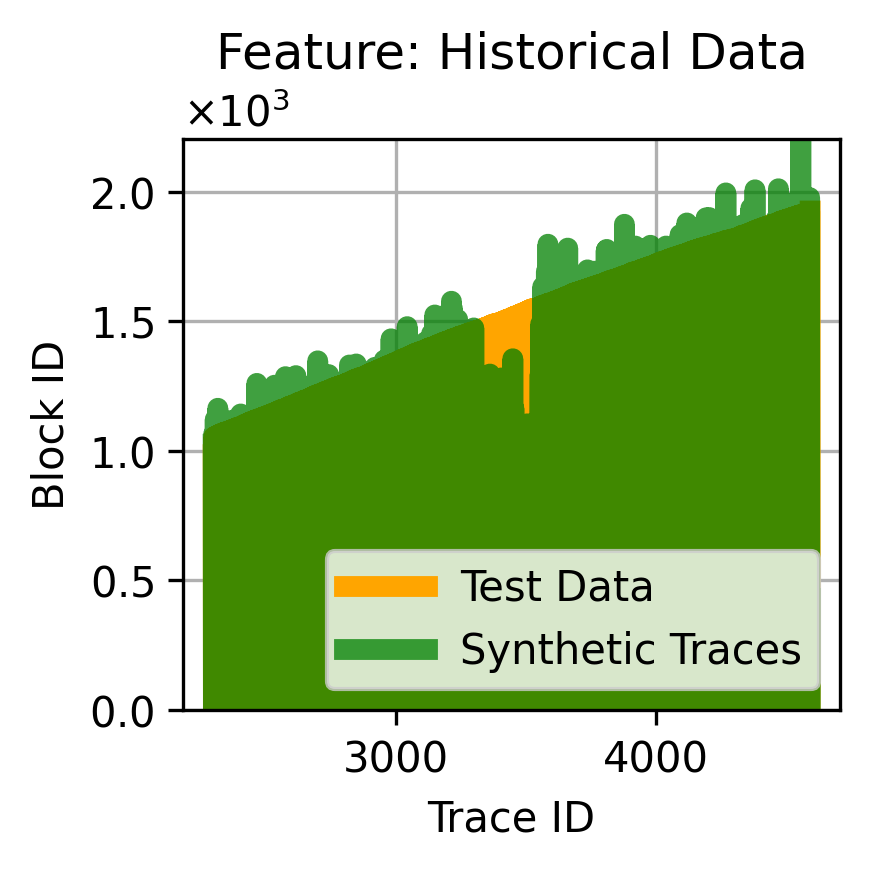

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'block_id':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Block ID')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

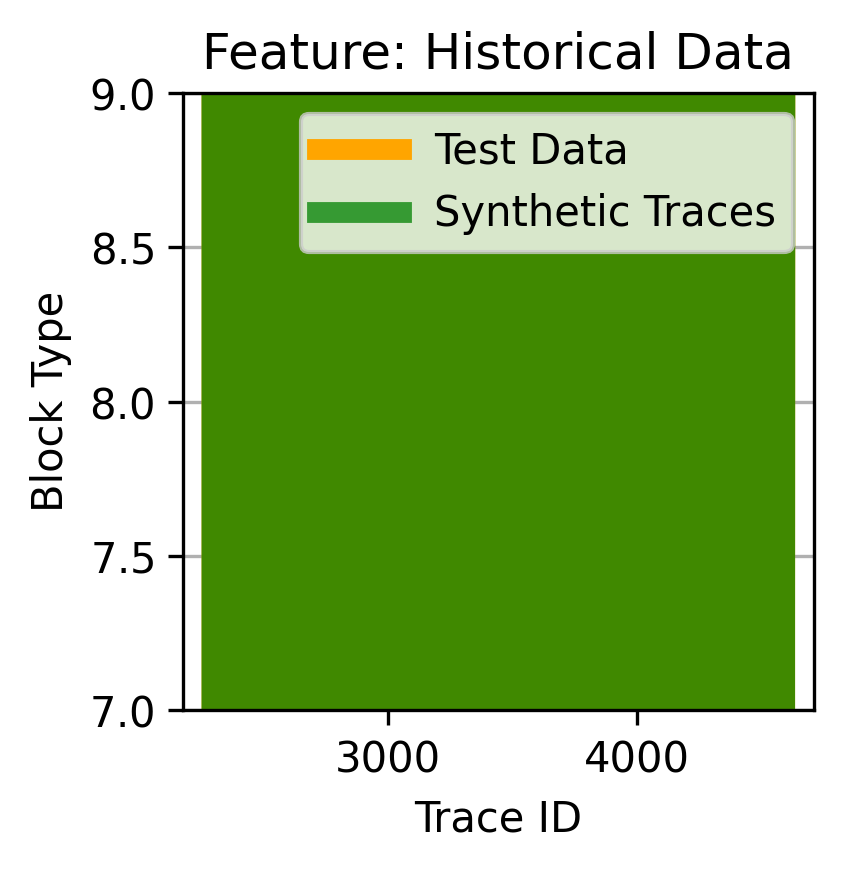

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'block_type':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Block Type')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

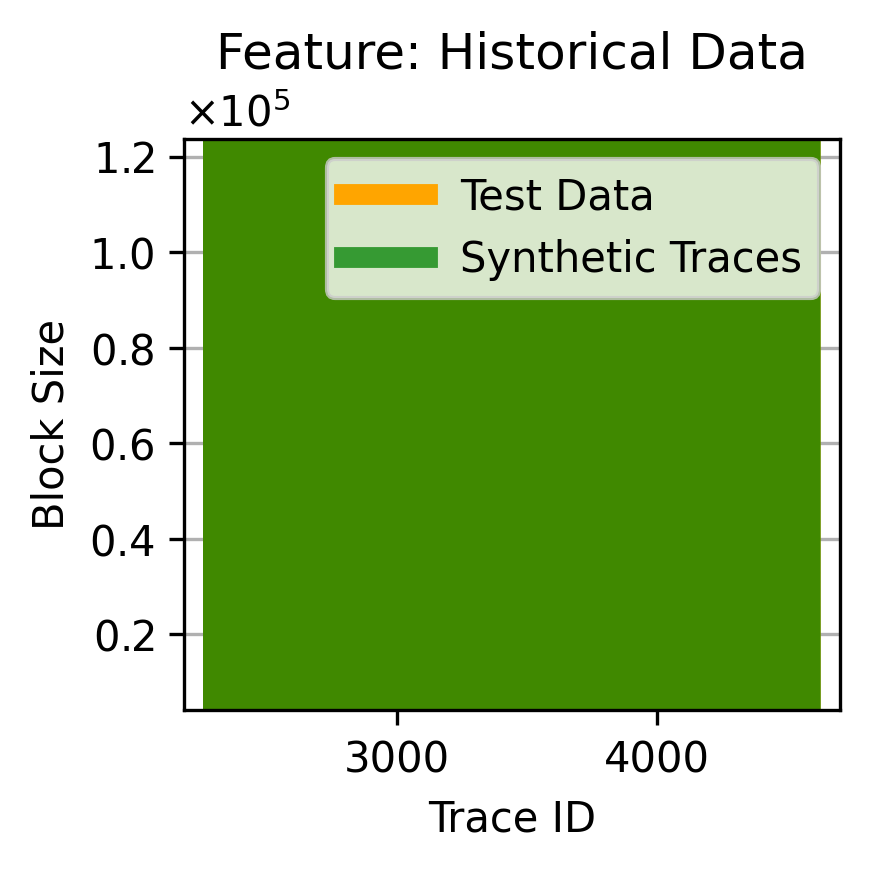

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'block_size':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Block Size')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

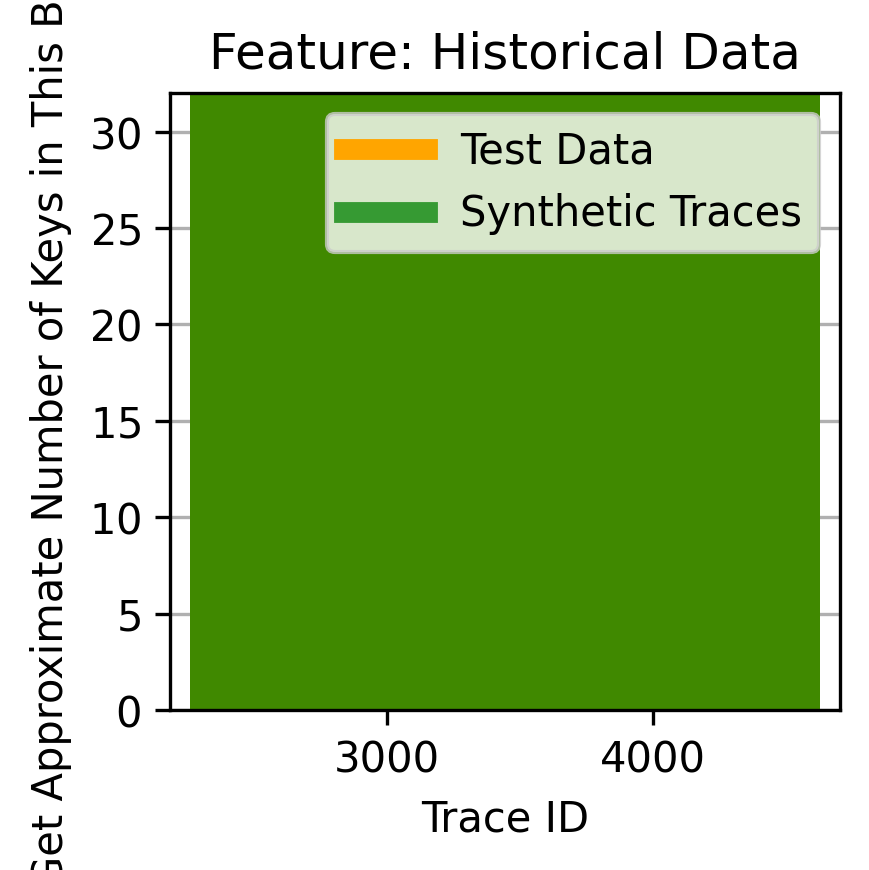

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'key_count':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Get Approximate Number of Keys in This Block')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

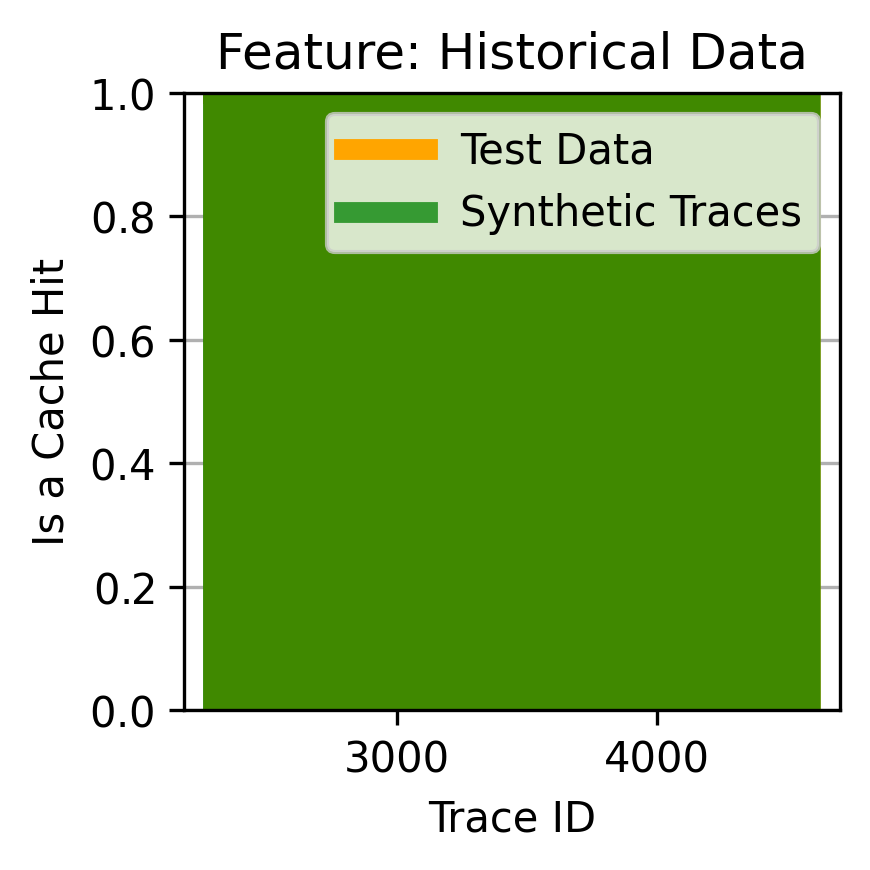

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'cache_hit':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Is a Cache Hit')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

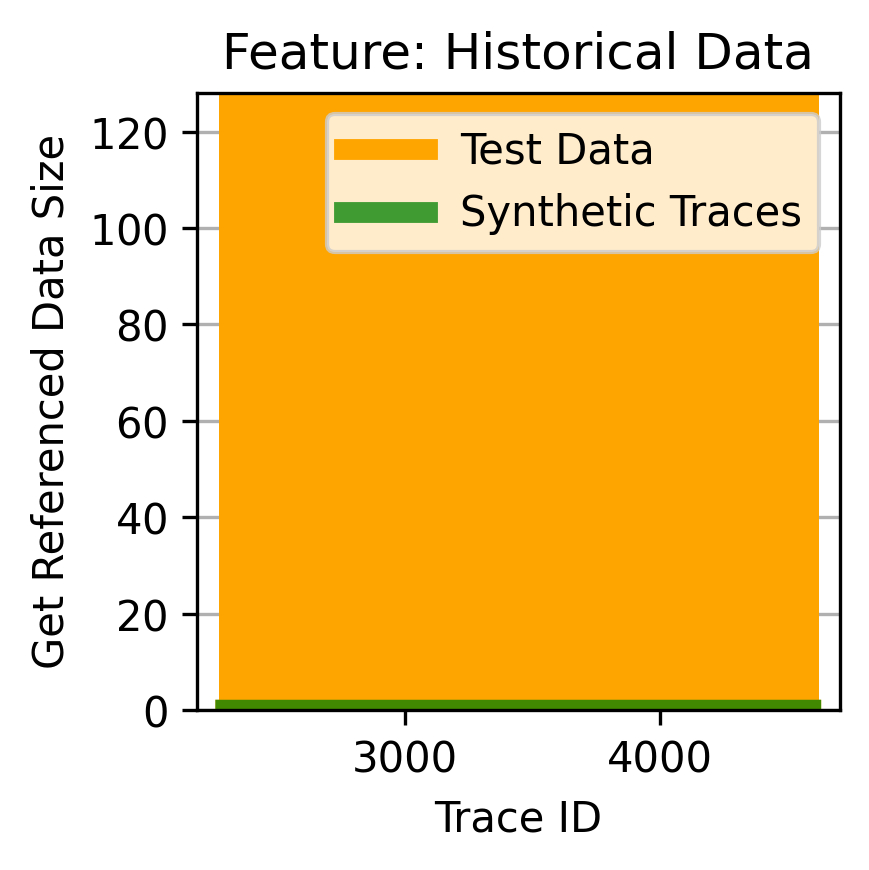

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'data_size':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Get Referenced Data Size')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
for col in train_data.columns:
    if col == 'data_size':
        plt.figure(figsize=(3, 3))
        min_y = min(min(test_data[col]), min(prediction_data[col]))
        max_y = max(max(test_data[col]), max(prediction_data[col]))
        plt.title('Feature: Historical Data')
        plt.plot(test_data[col], label='Test Data', linewidth=5, color='orange')
        plt.plot(prediction_data[col], label='Synthetic Traces', linewidth=5, alpha=0.75, color='green')
        plt.xlabel('Trace ID')
        plt.ylabel('Get Referenced Data Size')
        plt.ylim(min_y, max_y)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

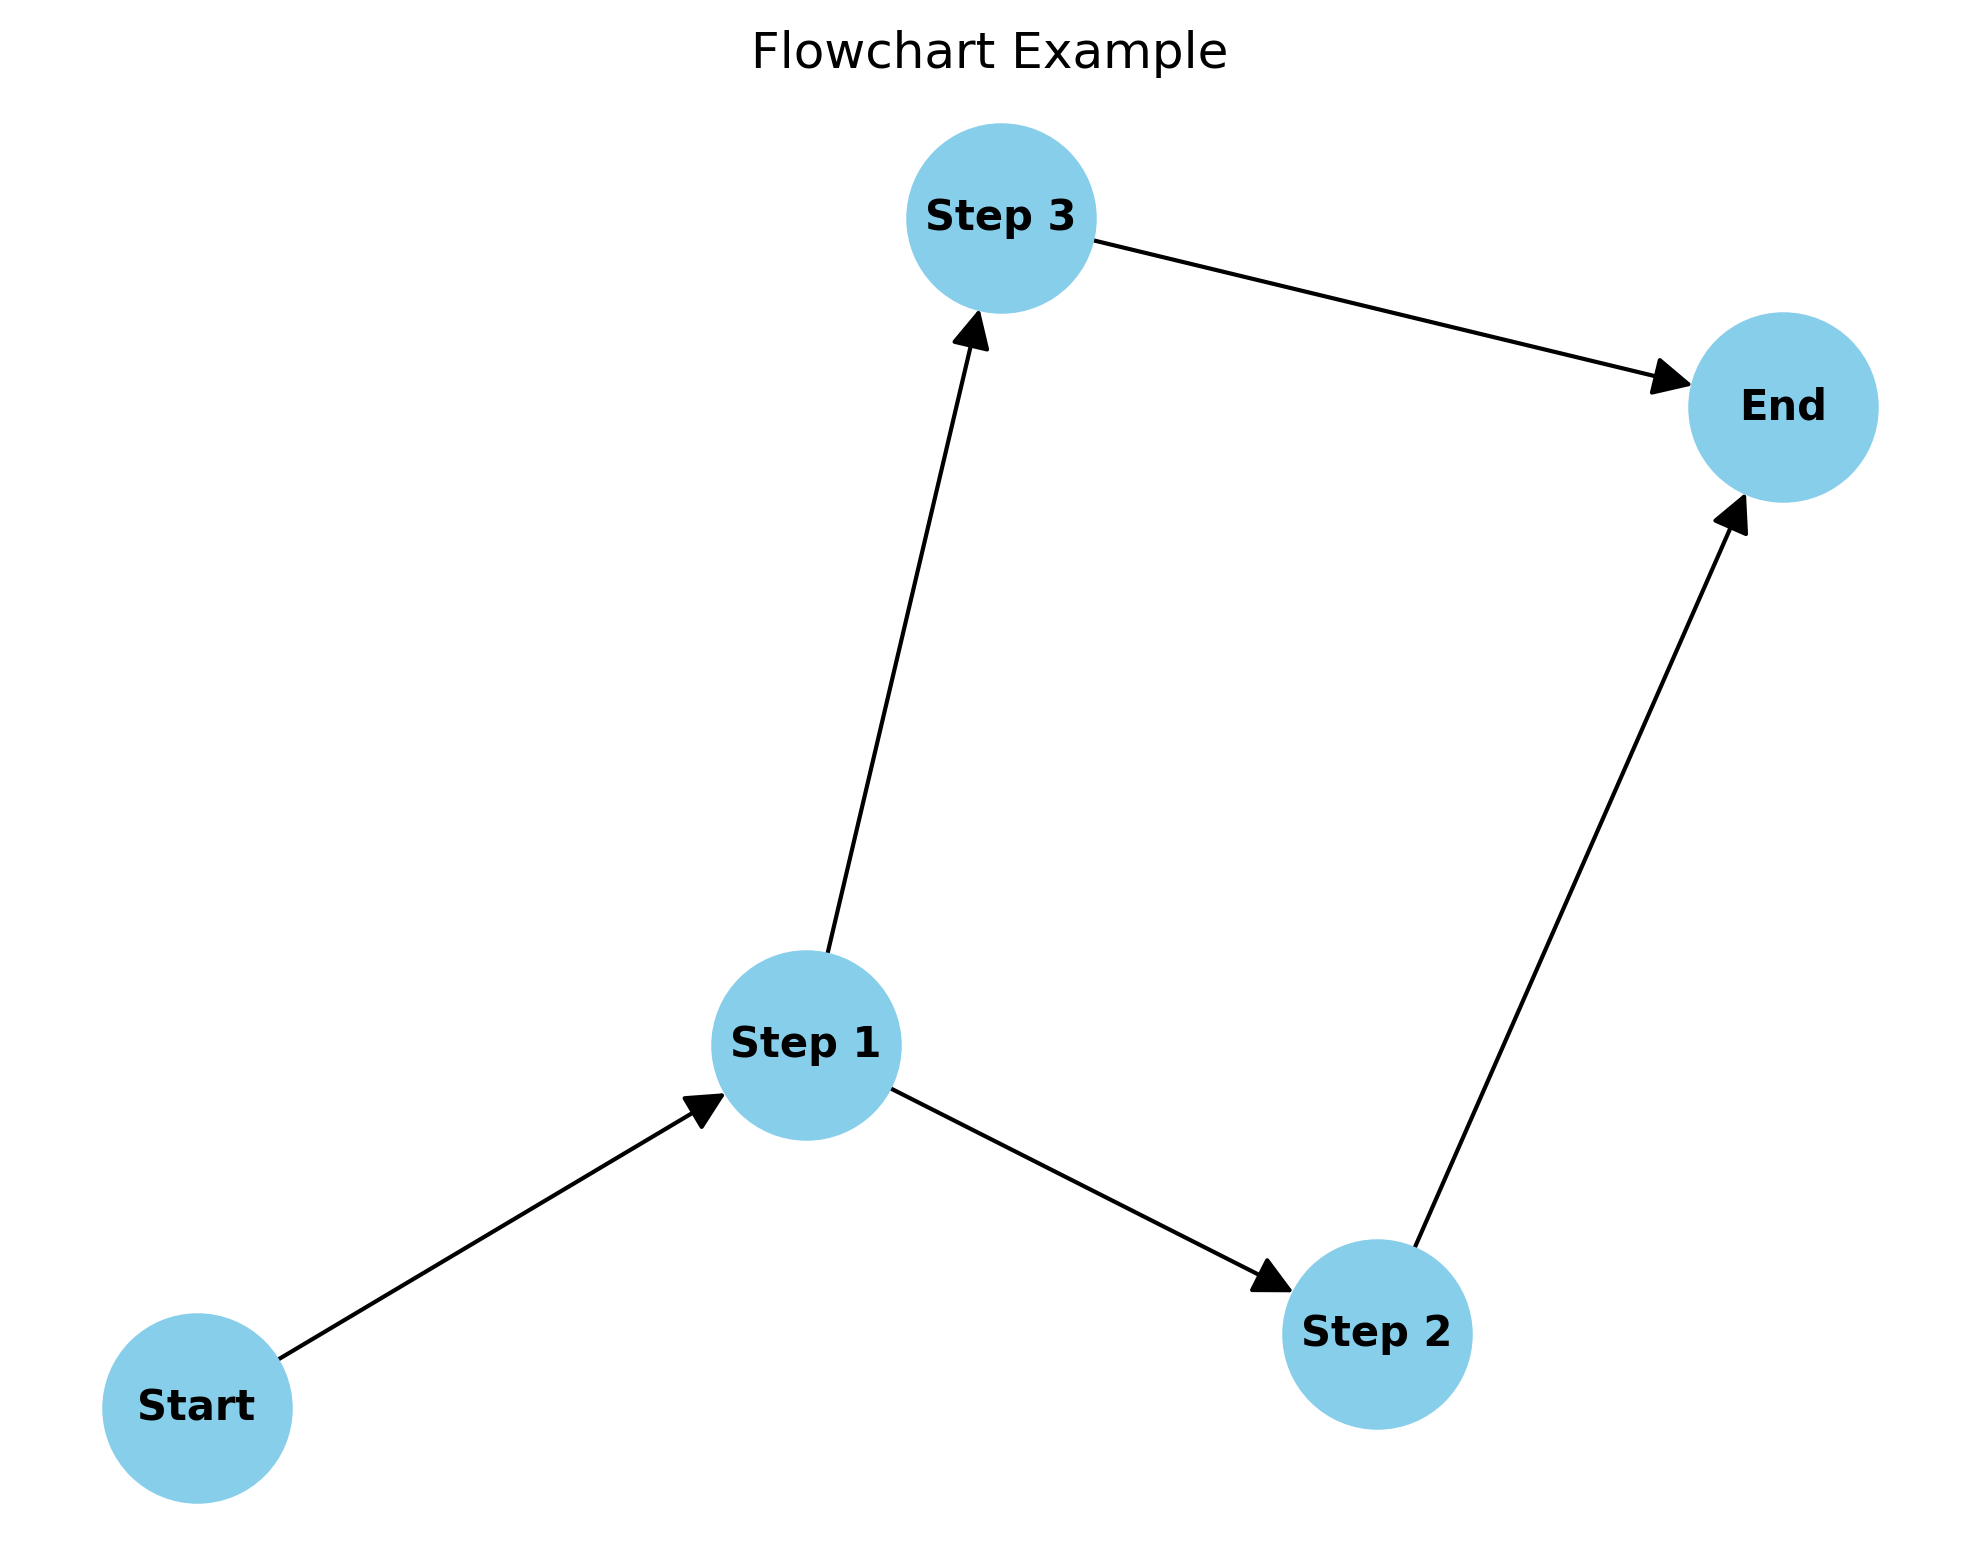

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Start")
G.add_node("Step 1")
G.add_node("Step 2")
G.add_node("Step 3")
G.add_node("End")

# Add edges
G.add_edge("Start", "Step 1")
G.add_edge("Step 1", "Step 2")
G.add_edge("Step 1", "Step 3")
G.add_edge("Step 2", "End")
G.add_edge("Step 3", "End")

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Set a seed for reproducibility
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title("Flowchart Example")
plt.show()


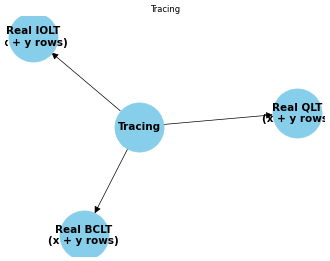

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 50
G = nx.DiGraph()
G.add_node("Tracing")
G.add_node("Real QLT\n(x + y rows)")
G.add_node("Real BCLT\n(x + y rows)")
G.add_node("Real IOLT\n(x + y rows)")
G.add_edge("Tracing", "Real QLT\n(x + y rows)")
G.add_edge("Tracing", "Real BCLT\n(x + y rows)")
G.add_edge("Tracing", "Real IOLT\n(x + y rows)")
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=5000, node_color="skyblue", font_size=15, font_weight="bold", arrowsize=20)
plt.title("Tracing")
plt.show()